In [80]:
import pandas as pd
import os                   
import openaq                    # pollutants api
import seaborn as sns             # draw plots
import numpy as np
from datetime import datetime   
import matplotlib.pyplot as plt
from meteostat import Point, Daily  # weather data api
import statsmodels.api as sm


# Project 2 report


***<font size="5">Introduction</font>***

***<font size="3">Background and Objective</font>***  

Particulate Matter 2.5, or, PM2.5 is the name designated to particles or droplets in the air that are 2.5 microns or less in width. Common sources of PM2.5 include emissions from vehicles, factories etc. And other activities involving burning fossil fuels such as petroleum and coal. Exposure to these particles can cause short-term health effects such as eye, nose, throat and lung irritation, and long-term exposure has been linked to increased rates of chronic bronchitis, reduced lung function, lung cancer and heart disease. PM2.5 levels are most likely to be elevated on days with little or no wind or air mixing and such levels can cause visibility issues and make the air appear hazy.  

It is intuitive to assume that there is correlation between weather and the PM2.5 level. For example, heavy rain and a gust of wind can decrease the regional PM2.5 concerntration. Thus we want to explore the this relation more formally with both visualization method and mathematical modelling. <span style='color:blue'>_The primary objective of this report is to investigate how the weather conditions such as precipitation, humidity, temperature etc will affect the PM2.5 concerntration. The secondary objective is forecasting the PM2.5 levels given information of weather._  

The object of study will be on the London, which has air quality data available from  8 different locations within the city and the surrounding area. Being a metropolitan city with a dense population. It is also of great importance that the air pollution levels be keenly monitored and strictly regulated. Additionally, the availability of pollution data from multiple sources reduces random error and affords us more accurate measurements of the city-wide average and, at the same time, allows us to observe the difference between pollution levels in different parts of the city depending upon population density, presence of industry, etc.  

***<font size="3">Report Structure</font>***  
1. ***Data collection:***  
The air quality data used in this report was collected from Openaq, which is an organisation that provides open source air quality data across the world to the public. This data is available on their website and may also be accessed through their API. The weather data used in this report was obtained from Meteostat's API.  This report set one day as the frequency so all observations are averaged on daily basis.

2. ***Visualization:***  
 Visualising the data helps us gain an intuition about its nature and also gives us insight into how it may be treated in order to produce meaningful results: The lineplot where the data of different stations are plot along with the dates to visualize if there is trend or seasonality. Density plots for different stations allow us to compare the distributions of levels of $PM{2.5}$ reported by each station. A spatial plot is included which shows us the location of each station on a map.  
 
 3. ***Formal Analysis:***    
 Now that we have a sense of direction, we can check for correlations between the weather variables and $PM{2.5}$ levels. We can isolate the ones with high correlation for further examination. Having carried out this analysis we are ready to build a time series model to account for the correlated residuals which allows forecasting. ACF and PACF plots help in determining the which Time Series process (MA, AR, ARMA, ARIMA) fits the residuals from the regression best, as well as the order of the process indicated by the correlations. Finally, we can test our model against real world data to gauge its accuracy. 




In [62]:
#####################
# No need to run    #
#####################
# The certificate of the Openaq expires? Can extract new data since 2021/12/1?
# Data is already prepared in CSV file
api = openaq.OpenAQ()
# We focus on Edinburgh and London
#################
# Data cleaning #
#################
start = datetime(2020,11,17)
end = datetime(2021,11,17)
# Request Pollution data together with the latitude and longitude of the location
# Measurement asks the user to specify the countries, cities, parameters (pm 2.5 for our analysis)
london = api.measurements(country = "GB",city="London", date_from = start,date_to = end ,df =True, parameter = "pm25",limit = 70000)

# Averaging the PM2.5 concentration by day
london = london.groupby([pd.Grouper(freq='D'),'location'],as_index=True).agg({'value':'mean','unit':'first','coordinates.latitude':'first','coordinates.longitude':'first'})


# Rename the columns and transform the string type
london['unit'] = london['unit'].str.decode('utf-8')
london.rename(columns = {"coordinates.latitude":"latitude",'coordinates.longitude':'longitude'},inplace=True)
london_location = Point(51.5072,0.1276)

# Fetch weather data for each station 
london_weather = Daily(london_location,start,end)                       # https://dev.meteostat.net/python/#example
london_weather = london_weather.fetch()

# Write the data, this files are only for testing purposes.
london.to_csv('Data_saved/london_test.csv')
london_weather.to_csv('Data_saved/london_weather_test.csv')




In [63]:
# ONLY executed once: Set up the data that will be used, so that it won't be affected by the later possible changes in the server
""" london.to_csv('Data_saved/london.csv')
edinburgh.to_csv('Data_saved/edinburgh.csv')
edinburgh_weather.to_csv('Data_saved/edinburgh_weather.csv')
london_weather.to_csv('Data_saved/london_weather.csv') """

" london.to_csv('Data_saved/london.csv')\nedinburgh.to_csv('Data_saved/edinburgh.csv')\nedinburgh_weather.to_csv('Data_saved/edinburgh_weather.csv')\nlondon_weather.to_csv('Data_saved/london_weather.csv') "

In [64]:
##################################
# Data prepared, Start from here #
##################################
london = pd.read_csv('Data_saved/london.csv',index_col=0)
london_weather = pd.read_csv('Data_saved/london_weather.csv',index_col=0)

In [65]:
# Variables in the data
london.head(5)

,location,value,unit,latitude,longitude
date.local,,,,,
2020-11-17,London Eltham,7.307692,µg/m³,51.452580,0.070766
2020-11-17,London Harlington,4.450000,µg/m³,51.488790,-0.441614
2020-11-17,London Marylebone Road,9.000000,µg/m³,51.522530,-0.154611
2020-11-17,London N. Kensington,5.000000,µg/m³,51.521050,-0.213492
2020-11-17,London Teddington Bushy Park,5.250000,µg/m³,51.425286,-0.345606


***<font size="3">Visualization</font>***  
1. ***Data Imputation and Lineplot:***  
Southwark A2 Old kent Road station seems to be a new station due to the fact that the data before about 2021-4-19 is not available. However, we are not going to use the imputed data in formal analysis because it loses information. Instead, we are using the averages of the 8 stations. When the value in a station is unavaible, it is removed from the calculation by default. As shown in the lineplot, in the observed one year, there is neither any significant trend nor any seasonal effect. The PM2.5 concerntration seems to fluctuate within the range of 0 to 20 $ug/m^3$, which could be a result of rapid change of other factors, such as weather, traffic volumes, factories' emissions etc.

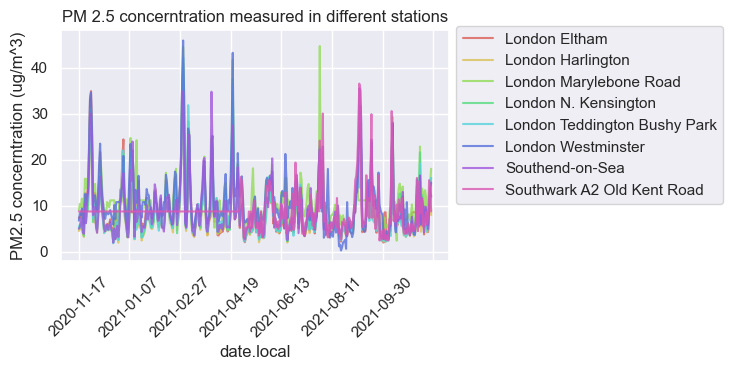

In [66]:
###########################
# Imputation and Lineplot #
###########################
# Plot the timeseries by stations.
# Transform into wide form 
# Impute the NA cells by mean value of each station
wide_form = london.pivot(columns='location',values='value').reset_index()
wide_form.fillna(wide_form.mean(),inplace=True)
# After imputation, we transform it back to long form.
imputed_long_form = wide_form.melt(id_vars=['date.local'], value_vars=wide_form.columns[1:9]).set_index('date.local')
# print(f"There are {len(london['location'].unique())} locations that measure the pollution level in london: {london['location'].unique()}")  
plt.figure(figsize=(5,3 ))
imputed_long_form.groupby('location')['value'].plot(legend=True,alpha=0.8)
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("PM 2.5 concerntration measured in different stations")
plt.ylabel('PM2.5 concerntration (ug/m^3)')
plt.xticks(rotation=45)
plt.show()

2. ***Spatial plot and Density plot:***  
As we plan to take averages of the observed PM2.5 values of the 8 stations, we want to check if there are significant differences among them or this operation can be misleading. In the spatial plot, we find out that the stations at Marylebone Road, Westminister have higher values on average while the other locations have similar distributions of PM2.5 values. This effect is understandable and intriguing as the city centre may have heavier traffic also denser population, thus more PM2.5 pollutions are produced. However, the difference is relatively small compared to the scale of the PM2.5 values, thus we can safely take their averages of 8 stations which reduce the measuring errors.

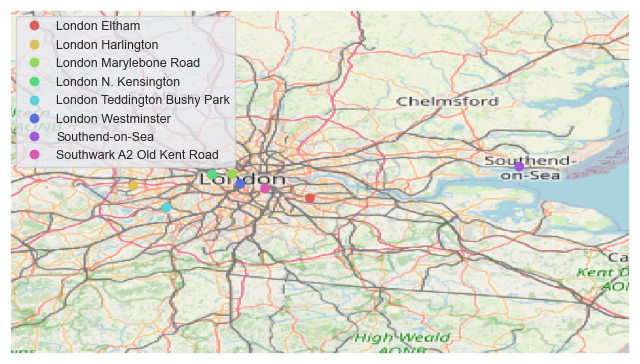

In [67]:
import cartopy.crs as ccrs # conda install PACKAGE -n ENVIRONMENT_name
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from matplotlib.colors import ListedColormap  # Customize color

# Give the location of london
london_lat,london_lon = 51.5072,0.1276
request = cimgt.OSM()

# Initialize a plot
map = plt.figure(figsize=(8,8))
uk = map.add_subplot(1,1,1,projection=ccrs.PlateCarree())
uk.set_extent([-0.8,1,52,51])


# Add the map as a background
uk.add_image(request, 8) # A better idea would be using real image

# Get the longitude and latitude of each station in london 
location_in_london = london.groupby('location')['longitude','latitude'].mean()
#print(location_in_london)
location_in_london['color_index'] = range(8)

# Create a color mapping so that it matches the seasborn's color
# Plot the locations of stations on the map
my_cmap = ListedColormap(sns.color_palette('hls',8))
uk_scatter = uk.scatter(location_in_london.longitude, location_in_london.latitude,transform =ccrs.PlateCarree(),c=location_in_london.color_index,cmap=my_cmap)
uk.legend(handles=uk_scatter.legend_elements()[0],labels = location_in_london.index.tolist(),prop={"size":9})
plt.show()


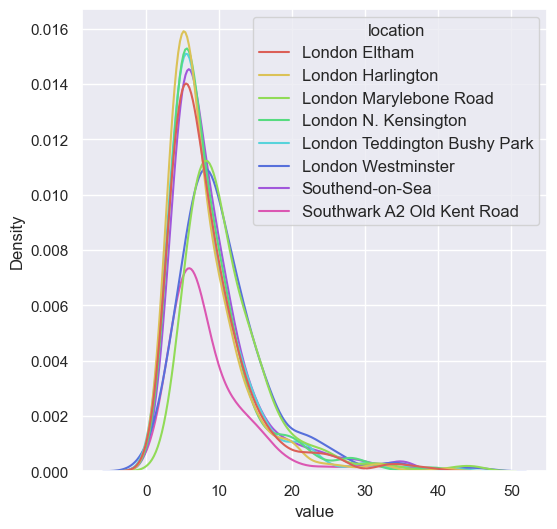

In [68]:
# Density plot
sns.set(rc={'figure.figsize':(6,6)})
sns.set_palette(sns.color_palette('hls',8))
distribution = sns.kdeplot(data = london, x='value', hue='location', multiple="layer")

# Adjust legend text
plt.setp(distribution.get_legend().get_texts(), fontsize='12') 
# Adjust legend title
plt.setp(distribution.get_legend().get_title(), fontsize='12')
plt.show() 

In [69]:
# Data cleaning for formal Analysis 
# Averaging the values of 8 stations.
avg_london = london.groupby('date.local')['value'].mean().to_frame()
london_merge = avg_london.join(london_weather)

# Drop the NA column
london_merge.dropna(axis = 1,how ='all',inplace=True) # Drop the columns that contains only NAs

***<font size="5">Formal Analysis </font>***  

***<font size="3">Part 1 Generalised Linear regression - Concurrent model & Cumulative model </font>***  
In the data cleaning stage, we firstly drop the empty columns in the weather data and join the pollutions data by dates. Then we drop the rows that contain any NAs.
The definition explanatory variables are defined below:
|Name|Definition                                  |
|-----|---------------------------------| 
|tavg|The average air temperature in °C |
|tmin|The minimum air temperature in °C | 
|tmax|The maximum air temperature in °C  |
|prcp|The daily precipitation total in mm | 
|wdir|The average wind direction in degrees (°)|  
|wspd|The average wind speed in km/h  |
|wpgt|The peak wind gust in km/h  |
|pres|The average sea-level air pressure in hPa | 
|value|The daily average PM2.5 concerntration values of the 8 stations in London|

Before modelling the generalised linear regression, by the heatmap, we explore the correlation among the explanatory data, also the correlation between the PM2.5 responses and the explanatory variables. It reveals that, there seems to be multicollinearity among tavg, tmin and tmax (correlation over 0.9), also between wspd and wpgt (correlation 0.88). So only five variables including tavg, prcp, wpgt, wdir, pres will be considered in the model (wpgt has higher correlation than wspd).

The regression formula is given by:
$$Y = \beta_0 + \beta_1*tavg +\beta_2*prcp+\beta_3*wpgt+\beta_4*wdir+\beta_5*pres+\epsilon$$
where the random errors are correlated as the response is a time series, $Y$ is a vector of length 349 (349 days left after data cleaning)$$\epsilon\sim N(0,\Sigma)$$

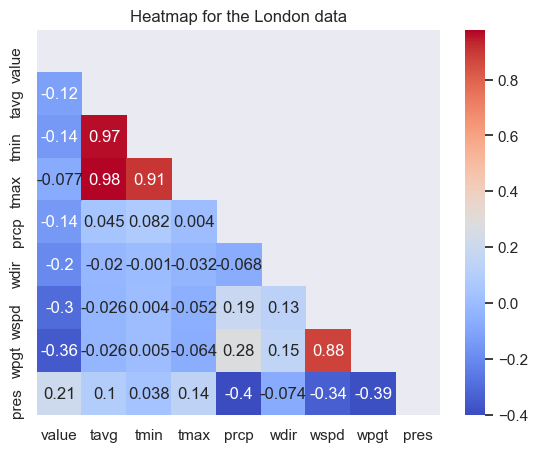

In [70]:
fig1,ax1 = plt.subplots(1,1,figsize = (6.5,5))
london_corr = london_merge.corr().round(3)
upper_triangle = np.triu(london_corr)  # The upper triangle will be 1 while the remain are 0.as_integer_ratio
# The cells where values take 1 while be hidden in heatmap
sns.heatmap(london_corr,mask=upper_triangle,annot=True,cmap='coolwarm',ax=ax1)
plt.title('Heatmap for the London data')
plt.show()

In [71]:
# Drop the columns that will not be used 
# In case you run it serveral time, errors = 'ignore' silence expections!
london_merge.drop(['tmin','tmax','wspd'],axis=1,inplace=True, errors='ignore')

In [72]:
####################
# Concurrent Model #
####################

#drop NA in each row

london_merge.dropna(axis=0,how='any',inplace=True)
train_simple = sm.add_constant(london_merge.drop('value',axis=1),prepend=False)
simple_mod = sm.GLS(london_merge['value'],train_simple)
simple_res = simple_mod.fit()
print(simple_res.summary())

                            GLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.174
Model:                            GLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     14.41
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           8.13e-13
Time:                        00:39:45   Log-Likelihood:                -1063.8
No. Observations:                 348   AIC:                             2140.
Df Residuals:                     342   BIC:                             2163.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tavg          -0.1423      0.051     -2.787      0.0

In [73]:
##############################
# Cumulative model London    #
##############################

# Shift the weather data, so that each row includes also the yesterday's data
london_shift = london_merge.join(london_merge.drop('value',axis=1).shift(periods = 1,axis=0),rsuffix='_yesterday')

#drop NA in each row
london_shift.dropna(axis=0,how='any',inplace=True)

# Fit and summarize OLS model
train_X = sm.add_constant(london_shift.drop('value',axis=1), prepend=False)
cum_mod = sm.GLS(london_shift['value'],train_X)
res = cum_mod.fit()
print(res.summary()) 


                            GLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.319
Model:                            GLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     15.77
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           3.20e-23
Time:                        00:39:45   Log-Likelihood:                -1027.5
No. Observations:                 347   AIC:                             2077.
Df Residuals:                     336   BIC:                             2119.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
tavg              -0.2700      0.149     -1.

***Remark***: It is predictatble that there are strong _multicollinearity_ as the weather data are time series. However, as our objective is to explore the effect of the variables, the significance is not referred thus it does not matter. 

Instead, we refer to $AIC$, ***Adjusted $R^2$*** to compare the concurrent model (including both today and yesterday's weather data as explanatory variables) and the cumulative model which only considers the effect of today's weather. It is obvious that including the yesterday's data makes a huge contribution to the explanation of the pollution concerntrations, as a result, $AIC$ decreases by 63 and adjusted $R^2$ almost doubles. That is, cumulative model can explains more variation than the concurrent model and thus choosed.
|Model type| Adjusted R squared | AIC |
|----------|--------------------|-----|
|Concurrent Model| 0.162 | 2140 |
|Cumulative Model| 0.299 | 2077 |

Conclusion: Looking at the coefficient of the explanatory varibles, it shows that the weather yesterday seems to affect the PM2.5 level more than weather today. In regard to the wind, the direction and speed have a negative effect on the PM2.5 concerntration. The daily total precipitation of both today and yesterday as expected have negative effects. It is a bit surprising that the average temperatures have also negative effect which may be validated in further study.

***<font size="3">Part 2 Time Series Analysis </font>***  
Following the regression modelling in part 1, we want to explore the correlation structure in the sequence of residuals of the regression. By subtracting the fitted value from the time series, the sequence of residuals has a mean that is about zero, so we assumes it to be stationary time series which have correlations as shown in ACF (<span style="color:blue"> Values of correlation at lag = 1 is estimated to be over 0.5, goes out of the 95% confidence interval</span>). Next, we conduct time-series analysis on this sequence of residuals. The steps of Time Series model building is specified below:

Firstly, we select the most appropriate model by observing the ACF and PACF plots of the sequence of residuals. ACF is an auto-correlation function which gives us values of auto-correlation of any series at each time lag. It describes how well the present value of the series is related with its past values. PACF is a partial auto-correlation function, and it finds correlation of the residuals with the next lag value.    

From the plots below, we can observe that the ACF plot shows a gradually decreasing trend, while the PACF has a sharp drop after 2 significant lags. Thus, the graphs suggest that an AR(2) model would be appropriate for the time series.



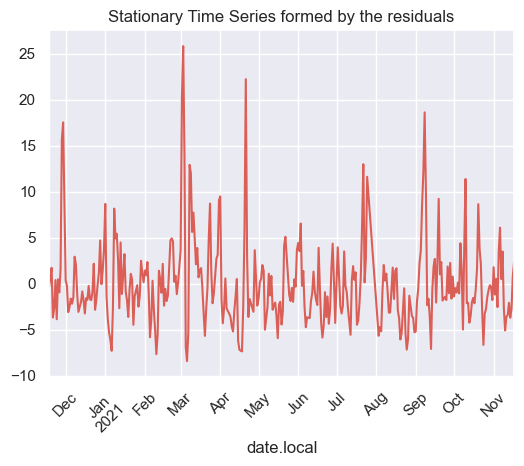

In [74]:
resid = res.resid
# Add a associated frequency which benefits later prediction
fig4,ax4 = plt.subplots(1,1,figsize=(6,4.5))
resid.index = pd.DatetimeIndex(resid.index).to_period('D')
resid.plot(ax = ax4)
plt.xticks(rotation = 45)
plt.title("Stationary Time Series formed by the residuals")
plt.show()

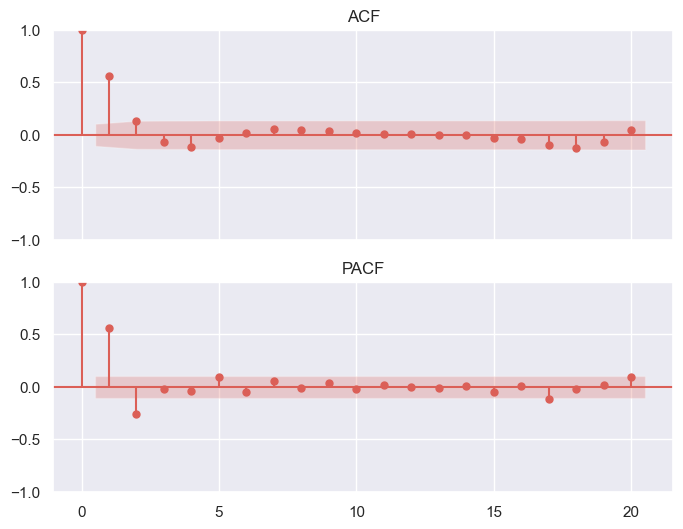

In [75]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig2,ax2=plt.subplots(2,1,sharex = True,figsize=(8,6))
# calculate and draw the autocorrelation function
plot_acf(resid, lags=20,ax=ax2[0])
ax2[0].set_title("ACF")

# calculate and draw the pacf
acf=plot_pacf(resid, lags=20,ax=ax2[1],method='ywm')
ax2[1].set_title("PACF")

plt.show()


***Remark***: Refer to the PACF plot, choose p as the smallest lag at which PACF value is significantly different from zero. Thus AR(2) model worths a try.
Definiton of AR(2) model:        
Let $X_t$ denote the residuals of the regression, and $\{Z_t\}_{t>=2}$ be a purely random process with mean zero and variance $\sigma^2$. $\alpha_{t-1}$ is the lag 1 coefficient, $\alpha_{t-2}$ is the lag 2 coefficient.       

$$X_t = \alpha_{t-1}*X_{t-1} + \alpha_{t-2}*X_{t-2} + Z_t$$

where, $$Z_t\sim N(0,\sigma^2)$$


In [76]:
AR2_mod = AutoReg(resid, 2, old_names=False)
AR2_res = AR2_mod.fit()
print(AR2_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  347
Model:                     AutoReg(2)   Log Likelihood                -946.188
Method:               Conditional MLE   S.D. of innovations              3.757
Date:                Wed, 08 Dec 2021   AIC                           1900.377
Time:                        00:39:46   BIC                           1915.751
Sample:                    11-20-2020   HQIC                          1906.499
                         - 11-17-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.202      0.003      0.997      -0.396       0.397
y.L1           0.7036      0.052     13.545      0.000       0.602       0.805
y.L2          -0.2640      0.052     -5.082      0.0

After we apply the AR(2) model, we plot the ACF and PACF again to check residuals from AR(2) if it is in line with the model assumption. And the figures show that our model of AR(2) is valid. Then we do the forecast part to predict the future pm2.5 data. The data preparation for forecasting is basically identical to what we have done for model training, but from 2021-11-18 to 2021-11-30.

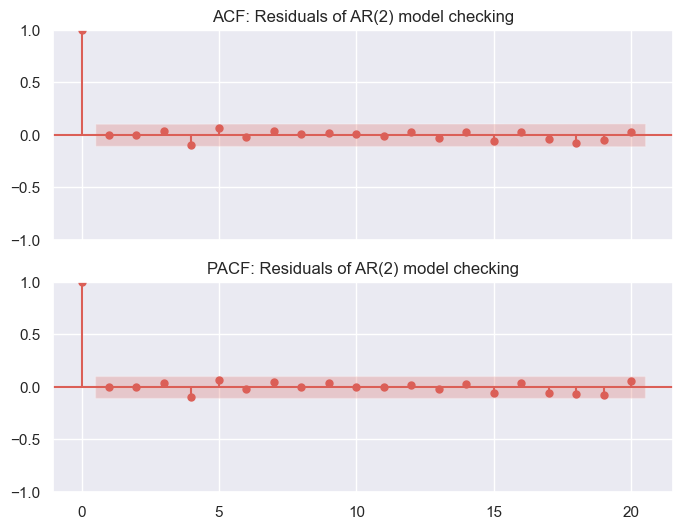

In [77]:
# calculate and draw the autocorrelation function
fig3,ax3 = plt.subplots(2,1,sharex = True,figsize=(8,6))
plot_acf(AR2_res.resid, lags=20,ax=ax3[0])
ax3[0].set_title("ACF: Residuals of AR(2) model checking")

# calculate and draw the pacf
acf=plot_pacf(AR2_res.resid, lags=20,ax=ax3[1],method='ywm')
ax3[1].set_title("PACF: Residuals of AR(2) model checking")

plt.show()

***Remark***: Indicated by the above plots, the residuals from the $AR(2)$ model are absolutely random. As expected, $AR(2)$ model is enough to capture all the correlation with the residuals from the earlier linear regression. 

In [78]:
###########################################
#Test data prepartion  (Once and for ever)#
###########################################

test_api = openaq.OpenAQ()
test_start = datetime(2021,11,17)
test_end = datetime(2021,12,7)
london_location = Point(51.5072,0.1276) # Define the location one more time
# Request UNSEEN pollution data from 2021-11-18 to 2021-12-7
test_london = test_api.measurements(country = "GB",city="London", 
date_from = test_start,date_to = test_end,df =True, parameter = "pm25",limit = 100000)
# Averaging by day
test_london = test_london.groupby([pd.Grouper(freq='D'),'location'],as_index=True).agg({'value':'mean','unit':'first','coordinates.latitude':'first','coordinates.longitude':'first'})
test_london = test_london.groupby('date.local')['value'].mean().to_frame()
test_london.to_csv('Data_saved/unseen_london.csv')
# Request UNSEEN weather data from 2021-11-18 to 2021-12-7
test_london_weather = Daily(london_location,test_start,test_end)
test_london_weather = test_london_weather.fetch()
# Drop unwanted variables in the weather data
test_london_weather.drop(['tsun','snow','tmin','tmax','wspd'],axis=1,inplace=True)
test_london_weather.to_csv('Data_saved/unseen_london_weather.csv')

***Forecasting Formula***: 
$$\widehat{{PM2.5}_{t+1}} = \widehat{Y_{t+1}} + \widehat{X_{t+1}}$$
where $Y_{t+1}$ is the predicted value by weather data on data $t+1$
and $X_{t+1}$ is the forecasted value from time series.

By virsaulizing the forecast, we found that the trend of our prediction is the same as the actual data. Almost all the data lies within the 95% confidence interval, which implies our forecast model is valid. 

Although we have done a decent job, there are still many details that should not be ignored. To research further and to forecast more accurately, we can find out more explanatory variables, such as traffic emissions, factory pollution emissions, geographical influence and ect. For these explanatory variables, we can firstly perform regression analysis on them to filter the variables, which means eliminate the variables with collinearity. Further, do the residual analysis on the remaining variables to represent their influence on the data. Finally, we perform the time-series analysis to the PM2.5 data which under the influence of the remaining variables. 

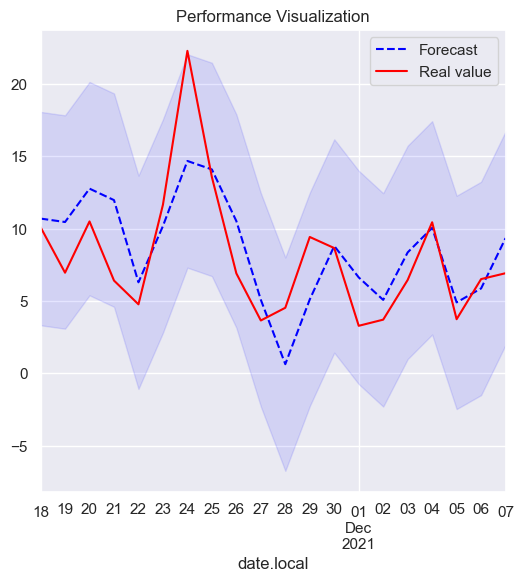

In [79]:
#############################################################
# For the testing part, Teammates can start from here       #
#############################################################
# Read in unseen data
test_london = pd.read_csv('Data_saved/unseen_london.csv',index_col=0)
test_london_weather = pd.read_csv('Data_saved/unseen_london_weather.csv',index_col=0)

# Join the response data and weather data
test_london_merge = test_london.join(test_london_weather)

# Shift the weather data, so that each row includes also the yesterday's data
test_london_shift = test_london_merge.join(test_london_weather.shift(periods = 1,axis=0),rsuffix='_yesterday')
#drop NA in each row
test_london_shift.dropna(inplace=True)
testing_data = sm.add_constant(test_london_shift.drop('value',axis=1),prepend=False)
# Predicting next unseen days by weather data
testing_prediction = res.predict(testing_data)

# Add the forcasted data from time series to the prediction by linear regression.
time_series_forecast = AR2_res.forecast('2021-12-7')['2021-11-18':'2021-12-7']
total_forecast = time_series_forecast.add(testing_prediction.values) 
#print('Total forecasting:\n',total_forecast)

total_forecast.plot(linestyle='dashed',color='blue',label = 'Forecast')
std = np.std(AR2_res.resid)
plt.fill_between(total_forecast.index.values, total_forecast.values-1.96*std, total_forecast.values+1.96*std 
, color='blue', alpha=0.1)

# Add the real data as a red line. 
# Convert the data index to a series with Frequecy label (Day)
test_london.index = pd.DatetimeIndex(test_london.index).to_period('D') 
test_london['value'].loc['2021-11-18':'2021-12-7'].plot(color='red',label = 'Real value')
plt.legend()
plt.title('Performance Visualization')
plt.show()
